In [1]:
import matplotlib
import numpy as np
import sys
import random
import holopy as hp, numpy as np
from holopy.scattering import calc_holo,Sphere
import cv2
import matplotlib.pyplot as plt
import random
from tensorflow.keras.optimizers import SGD
import tqdm
import math

In [3]:
def create_training_Data():
    med_n = 1 #air
    wl = 0.66 #red light
    pol=(0,1) #polarization
    camera = hp.detector_grid(shape=128, spacing=1.12)
    l = 10000
    X_train = np.zeros(shape=[l,128, 128,1,1])
    Y_train = np.zeros(shape = [l,1])
    for i in range(l):
        na=round(random.uniform(0.30,0.95),2)
        rad = 0.66/(8*na)
        c_x,c_y = random.randint(5,127),random.randint(5,127)
        c_z = 71.68*(math.sqrt((1-pow(na,2))/pow(na,2)))
        #Y_train[i,0]= c_x
        #Y_train[i,1] = c_y
        Y_train[i,0] = c_z
        #Y_train[i,3] = rad
        au=Sphere(n=0.2+2.9j,r=rad,center=(c_x,c_y,c_z))#gold particle specification
        X_train[i,:,:,:,0] = calc_holo(camera,au,med_n,wl,pol)
        
    return {'X_Train' : X_train, 'Y_Train': Y_train};

In [4]:
training_Data = create_training_Data();

In [5]:
training_Data['Y_Train'][0]

array([88.35926842])

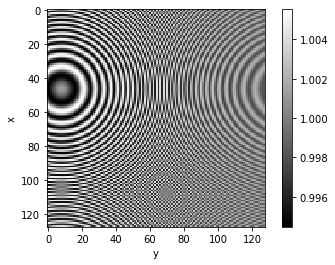

In [6]:
hp.show(training_Data['X_Train'][15].reshape(128,128))

In [7]:
training_Data['Y_Train'][100]

array([185.7611697])

In [8]:
import tensorflow;
from tensorflow.keras import layers;
from tensorflow.keras import Model;

In [9]:
print(tensorflow.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
from keras.layers import BatchNormalization
img_input = layers.Input(shape=(128, 128,1))
x = layers.Conv2D(5, 3, activation='swish', strides = 1, padding = 'same')(img_input)
x = BatchNormalization(axis=-1)(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(10, 3, activation='swish', strides = 2)(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = BatchNormalization(axis=-1)(x)
x = layers.Conv2D(20, 3, activation='swish', strides = 2)(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = BatchNormalization(axis=-1)(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='swish')(x)
x = layers.Flatten()(x)
output = layers.Dense(1, activation='swish')(x)
model = Model(img_input, output)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 5)       50        
                                                                 
 batch_normalization_6 (Batc  (None, 128, 128, 5)      20        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 5)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 31, 31, 10)        460       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 15, 10)       0   

In [17]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse']);

In [18]:
model.fit(training_Data["X_Train"],training_Data["Y_Train"], epochs = 100,verbose=1,batch_size=32)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.